$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Linear Regression with Fixed Nonlinear Features

The models we have been buildling are linear in the parameters $\wv$
and linear in the attributes (features) of the samples.  We can make
models that are nonlinear in the attributes by adding nonlinear
functions of the original features.  

Say we have a single feature for each sample.  Our data matrix is
$$
\begin{alignat*}{1}
 X &= \begin{bmatrix}
       x_0\\
       x_1\\
       \vdots \\
       x_N
       \end{bmatrix}
\end{alignat*}
$$
We can add other powers of each $x$ value, say up to the fourth power.
$$
\begin{alignat*}{1}
 X &= \begin{bmatrix}
       x_0 & x_0^2 & x_0^3 & x_0^4\\
       x_1 & x_1^2 & x_1^3 & x_1^4\\
       \vdots \\
       x_N & x_N^2 & x_N^3 & x_N^4\\
       \end{bmatrix}
\end{alignat*}
$$

This is simple to do in python.

    X = np.hstack((X, X**2, X**3, X**4))

Which of these powers of $x$ are useful?  Looking at the magnitudes of
the weights is helpful, as long as the input features are
standardized.  We can do more than this, though.  If we build multiple
models from multiple bootstrap samples of the training data, we can
compute confidence intervals of the weight values.  If zero is
not included in the range of
weight values specified by a weight's 90% lower and
upper confidencce limit, then we can say that we are 90% certain that
the value of this weight is not zero.  If the range does include zero,
the corresponding feature is probably one that is not useful.

Here is some code that illustrates this whole process, including the
use of the penalty on weight magnitudes controlled by $\lambda$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random

In [4]:
def train(X,T,lamb=0):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.insert((X - means)/stds, 0, 1, axis=1)
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( Xs1.T @ Xs1 + lambDiag, Xs1.T @ T)[0]
    return {'w': w, 'means':means, 'stds':stds, 'lambda': lamb}

def use(model, X):
    Xs1 = np.insert((X-model['means'])/model['stds'], 0, 1, axis=1)
    return Xs1 @ model['w']

def rmse(A,B):
    return np.sqrt(np.mean( (A-B)**2 ))


Now, make a simple function of $x$. How about $f(x) = -1 + 0.1 x^2 - 0.02 x^3 + 0.5 n$, where $n$ is from a standard Normal distribution.

In [5]:
nSamples = 40
trainingFraction = 0.5
nModels = 1000
confidence = 90 # percent
lambdaw = 0.0 # penalty on weight magnitudes

X = np.hstack((np.linspace(0, 3, num=nSamples),
               np.linspace(6, 10, num=nSamples))).reshape((2*nSamples,1))
# T = -1 + 1 * X + 2 * np.sin(X*2) + 0.55*np.random.normal(size=(2*nSamples,1))
T = -1 + 0 * X + 0.1 * X**2 - 0.02 * X**3 + 0.5*np.random.normal(size=(2*nSamples,1))
X.shape, T.shape

((80, 1), (80, 1))

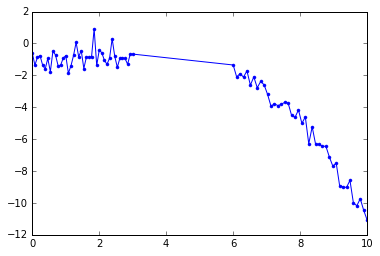

In [6]:
plt.plot(X,T,'.-');

Let's add squared and cubed values of each feature.

In [36]:
Xf = np.hstack((X, X**2, X**3, X**4, X**5))
#Xf = np.hstack((X, np.sin(X)))

Divide data into training and testing sets, randomly.

In [37]:
random.sample([1,2,3,4,5],4)

[1, 5, 2, 4]

In [38]:
round(7.8)

8

In [39]:
nRows = Xf.shape[0]
nTrain = round(nRows*trainingFraction)
nTest = nRows - nTrain)) #
allI = range(nRows)
trainI = random.sample(allI,nTrain)
testI = list(set(allI).difference(set(trainI)))

Xtrain = Xf[trainI,:]
Ttrain = T[trainI,:]
Xtest = Xf[testI,:]
Ttest = T[testI,:]

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((40, 5), (40, 1), (40, 5), (40, 1))

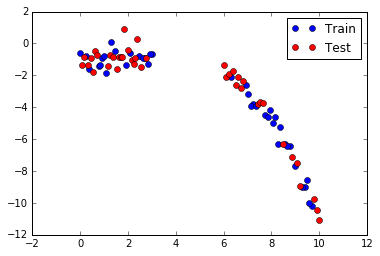

In [40]:
plt.plot(Xtrain[:,0],Ttrain,'o',label='Train')
plt.plot(Xtest[:,0],Ttest,'ro',label='Test')
plt.xlim(-2,12)
plt.legend(loc='best');

Make models based on bootstrap samples of training data.  *models* will be list of models, one for each bootstrap sample.

In [41]:
[random.randint(0,10) for i in range(20)]

[2, 7, 3, 7, 1, 4, 1, 9, 6, 7, 1, 6, 6, 10, 7, 8, 9, 3, 6, 9]

In [42]:
nModels = 100
models = []
for modeli in range(nModels):
    # Draw random sample (row) numbers, with repetition
    trainI = [random.randint(0,nTrain-1) for i in range(nTrain)]
    XtrainBoot = Xtrain[trainI,:]
    TtrainBoot = Ttrain[trainI,:]
    model = train(XtrainBoot,TtrainBoot,0)
    models.append(model)

In [43]:
len(models)

100

In [44]:
models[0]

{'lambda': 0,
 'means': array([  5.65961538e+00,   4.44339086e+01,   3.77890597e+02,
          3.30329614e+03,   2.92653686e+04]),
 'stds': array([  3.52174137e+00,   3.64544086e+01,   3.44688475e+02,
          3.22979674e+03,   3.04056967e+04]),
 'w': array([[ -4.23713943],
        [  0.50059623],
        [ -1.9393907 ],
        [ -5.02570794],
        [ 14.02368036],
        [-10.96801125]])}

Now we will apply all of the models to the test data.

In [45]:
YAll = []
for model in models:
    YAll.append( use(model, Xtest) )

In [46]:
np.array(YAll).squeeze().shape

(100, 40)

In [47]:
YAll = np.array(YAll).squeeze().T 
Ytest = np.mean(YAll,axis=1)

In [48]:
Ytest.shape

(40,)

In [49]:
Ttest.flatten().shape

(40,)

In [50]:
Ttest = Ttest.flatten()  ## WATCH OUT!! Next line produces wrong scalar without this line!
RMSEtest = np.sqrt(np.mean((Ytest - Ttest)**2))
print('Test RMSE is {:.4f}'.format(RMSEtest))

Test RMSE is 0.5602


(-5, 5)

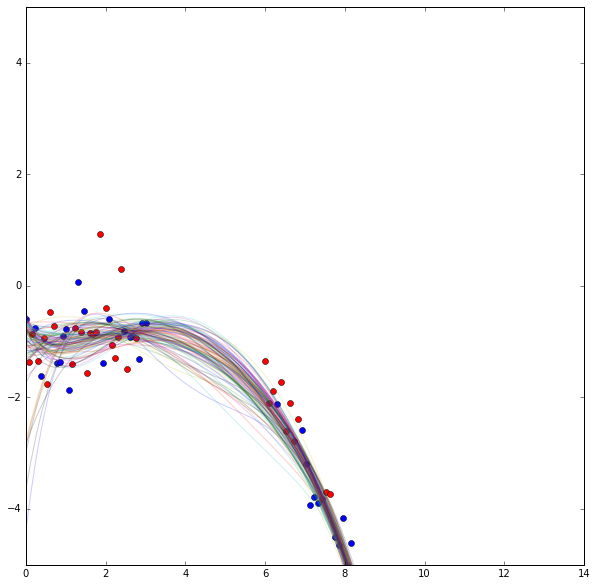

In [53]:
nPlot = 100
Xplot = np.linspace(0,13.5,nPlot).reshape((nPlot,1))
Xplotf = np.hstack((Xplot,Xplot**2,Xplot**3,Xplot**4,Xplot**5))
Ys = []
for model in models:
    Yplot = use(model, Xplotf)
    Ys.append( Yplot.flatten())
Ys = np.array(Ys).T

plt.figure(figsize=(10,10))
plt.plot(Xtrain[:,0],Ttrain,'o');
plt.plot(Xtest[:,0],Ttest,'ro');
plt.plot(Xplotf[:,0],Ys,alpha=0.2);
plt.ylim(-5,5)


Now let's try some other data.  Here is some data recorded from EMG sensors and one column of resulting joint forces.  This data is from [this UCI repository](https://archive.ics.uci.edu/ml/datasets/EMG+dataset+in+Lower+Limb#).  There you will see that the data has 4 channels of EMG and one of force, measured at the knee of 22 subjects.

In [54]:
!wget http://www.cs.colostate.edu/~anderson/cs480/notebooks/emg.txt
!head emg.txt

--2017-02-06 09:33:02--  http://www.cs.colostate.edu/~anderson/cs480/notebooks/emg.txt
Resolving www.cs.colostate.edu (www.cs.colostate.edu)... 129.82.45.114
Connecting to www.cs.colostate.edu (www.cs.colostate.edu)|129.82.45.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9279142 (8.8M) [text/plain]
Saving to: ‘emg.txt.2’

emg.txt.2           100%[===================>]   8.85M   848KB/s    in 11s     

2017-02-06 09:33:13 (859 KB/s) - ‘emg.txt.2’ saved [9279142/9279142]

1.500e-03 -8.000e-04 -4.600e-03 7.000e-04 3.000e+00
3.000e-03 4.500e-03 -1.580e-02 -8.000e-04 3.000e+00
3.700e-03 4.500e-03 -1.650e-02 -8.000e-04 3.000e+00
0.000e+00 3.700e-03 -1.730e-02 -1.500e-03 3.000e+00
-8.000e-04 7.000e-04 -1.200e-02 -1.500e-03 3.000e+00
0.000e+00 7.000e-04 -6.800e-03 7.000e-04 3.000e+00
-8.000e-04 7.000e-04 -2.300e-03 7.000e-04 3.000e+00
7.000e-04 -3.000e-03 -1.500e-03 7.000e-04 3.000e+00
-4.600e-03 -6.000e-03 -8.000e-04 0.000e+00 3.000e+00
-6.000e-03 -4.600e-03 1.1

In [55]:
data = np.loadtxt('emg.txt')

T = data[:,-1:]
X = data[:,:-1]
X.shape,T.shape

((177179, 4), (177179, 1))

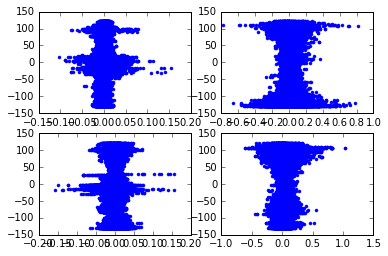

In [56]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(X[:,i],T,'.')

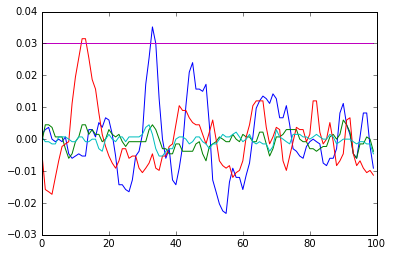

In [59]:
plt.plot(X[:100,:]);
plt.plot(T[:100,:]/100)

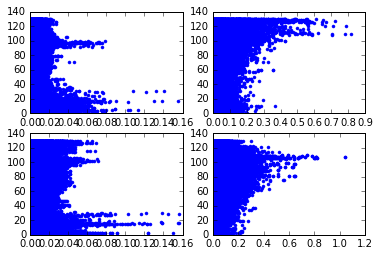

In [60]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(np.abs(X[:,i]),np.abs(T),'.')

Now, let's try fitting a linear model to this data.

In [73]:
(1,)

(1,)

In [77]:
Xf = np.hstack([X,X**2])

In [78]:
model = train(Xf,T)
predict = use(model, Xf)
print(rmse(predict,T))

57.5897204972


In [88]:
list(range(2,20,2))

[2, 4, 6, 8, 10, 12, 14, 16, 18]

In [89]:
result = []
for deg in range(2,20,2):
    Xf = X # .copy()
    for d in range(2,deg+1):
        Xf = np.hstack((Xf, X**d))
    err = rmse( use( train(Xf, T), Xf), T)
    #print(deg, Xf.shape)
    result.append([deg,err])
result = np.array(result)
result

array([[  2.        ,  57.5897205 ],
       [  4.        ,  57.22976342],
       [  6.        ,  56.95391405],
       [  8.        ,  56.73856375],
       [ 10.        ,  56.57235124],
       [ 12.        ,  56.45876493],
       [ 14.        ,  56.35171333],
       [ 16.        ,  56.27032765],
       [ 18.        ,  56.20098811]])

In [ ]:
Xf.shape


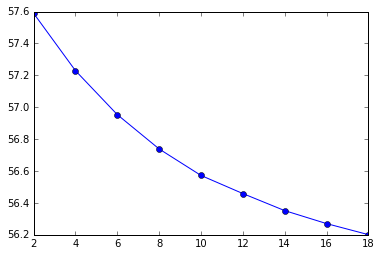

In [90]:
plt.plot(result[:,0],result[:,1],'o-');

In [91]:
!ls *npz

index.npz  thumb.npz


In [92]:
data = np.load('thumb.npz')

In [93]:
data.keys()

['data']

In [94]:
emg = data['data']

In [95]:
emg.shape

(411530, 12)

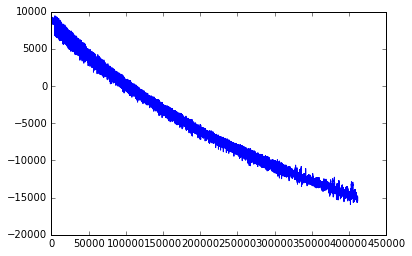

In [96]:
plt.plot(emg[:,0])

In [ ]:
ch1 = emg[:,0]
w = 